In [132]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.svm import SVC  
import random
from xgboost import XGBClassifier
import warnings
warnings.filterwarnings('ignore')

In [166]:
df = pd.read_csv('google_books.csv')
count_one_hot_words = pd.read_csv('count_one_hot_words.csv')
tfidf_one_hot_words = pd.read_csv('tfidf_one_hot_words.csv')
print(df.shape)

(1116, 14)


In [167]:
df.dropna(subset=['description'], inplace=True)
df.reset_index(inplace=True, drop=True)
print(df.shape)
df.head()

(1111, 14)


,title,subtitle,authors,publisher,month,year,categories,pageCount,listPrice,images,isEbook,ratingsCount,averageRating,description
0,The Litigators,NaN,John Grisham,Dell,10,2011,Fiction,496,9.99,False,True,137,3.5,The partners at Finley & Figg often refer to t...
1,Ragtime,A Novel,E.L. Doctorow,Random House,11,2010,Fiction,336,14.99,True,True,57,3.5,Selected by the Modern Library as one of the 1...
2,Her Perfect Man,NaN,Mary Lynn Baxter,Silhouette,5,2011,Fiction,192,3.99,False,True,1,5.0,One look at firebrand Katherine Mays and Bryce...
3,The Vanished Man,A Lincoln Rhyme Novel,Jeffery Deaver,Simon and Schuster,8,2012,Fiction,577,NaN,False,False,19,4.0,Hunting down a killer and master illusionist w...
4,One Sunday,A Novel,Carrie Gerlach Cecil,Simon and Schuster,2,2013,Fiction,255,NaN,False,False,6,4.0,"When her unborn child's health is put at risk,..."


## Feature Engineering

In [168]:
## target feature indicating if book gets a 4.5 rating or above
def above4p5(x):
    if x >= 4.5:
        return 1
    else:
        return 0

df['above4p5'] = df['averageRating'].map(lambda x: above4p5(x))

In [169]:
## make feature that indicates if popular or unpopular author 
## i.e. does the author appear more than once 
author_count = df.authors.value_counts()
popular_authors = list(author_count[author_count >= 3].index)

def popular_author(x):
    if x in popular_authors:
        return 1
    else:
        return 0

df['popular_author'] = df['authors'].map(lambda x: popular_author(x))
print(df['popular_author'].sum())

21


In [170]:
words = tfidf_one_hot_words.iloc[:,0:49]

df = pd.concat([ pd.get_dummies(df['publisher']), pd.get_dummies(df['month']), 
                     pd.get_dummies(df['year']), pd.get_dummies(df['categories']), 
                df['images'], df['isEbook'], df['popular_author'], df['above4p5']], axis=1)
df = pd.concat([df, words], join="inner", axis=1)
df.head()

,A&C Black,A&amp;C Black,Abrams,Academic Press,Acculant Publishing,Ace,Addison-Wesley,Addison-Wesley Professional,Adelphi Edizioni spa,African Books Collective,...,year,guide,readers,recipes,man,novel,students,just,real,design
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,1,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


##### Solving imbalances in the train test split due to uneven distribution of words

In [171]:
## this cell makes a train-test-split based on dataframe index
## it is taking random samples of words (column) and splitting it into a mini
## train-test dataframe then merging to a running tally of random samples
## once the running tally reaches approximately 75% of the main dataframe,
## the loop halts
freq_words = words.apply(np.sum, axis=0)

## initialze empty dataframes
train = pd.DataFrame(columns = df.columns)
test = pd.DataFrame(columns = df.columns)

## while loop until train dataframe reaches 75% of main df n_rows
while train.shape[0] <= round(len(df.index) * 0.75):
    ## sample a word and split in to train/test based on the word
    samp = freq_words[freq_words<100].sample(1).index[0]
    col = tfidf_one_hot_words[[samp]]

    ## gets all the rows where that word occurs
    col = col[col[samp]==1]

    ## estimate of how many rows we want in micro train dataset
    n_train = round(len(col.index) * 0.75)

    ## get a sample of the indices that go in to the micro train dataset
    inds = random.sample(range(0,len(col.index)), k=n_train)
    train_inds = [list(col.index)[ind] for ind in inds]

    ## gtakes difference between train indices and micro dataframe indices to get test in  dices
    test_inds = list(set(list(col.index))- set(train_inds))

    ## join the micro indices with the macro indices, which we will continue to add to
    train = pd.concat([train, df.iloc[train_inds]])
    test = pd.concat([test, df.iloc[test_inds]])

In [172]:
print(train.shape)
train.head()


(865, 465)


,A&C Black,A&amp;C Black,Abrams,Academic Press,Acculant Publishing,Ace,Addison-Wesley,Addison-Wesley Professional,Adelphi Edizioni spa,African Books Collective,...,year,guide,readers,recipes,man,novel,students,just,real,design
1008,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
965,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,1,0,0
967,0,0,0,0,0,0,0,0,0,0,...,0,0,1,1,0,0,0,0,0,0
993,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
1010,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,1,0,1


In [173]:
## manually making the train-test-split
X_train = train.drop(['above4p5'], axis=1)
y_train = train[['above4p5']]

X_test = test.drop(['above4p5'], axis=1)
y_test = test[['above4p5']]
                     
# x_sub = X_train.drop([''])


In [174]:
y_train=y_train.astype('int')
y_test = y_test.astype('int')

## Baseline

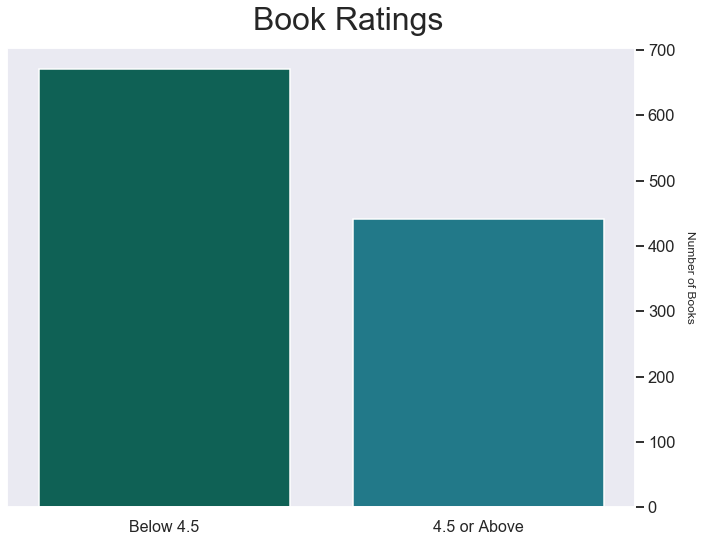

In [175]:
sns.set(style='dark', context='talk')
palette = sns.color_palette("PuBuGn_r")

f, ax = plt.subplots(figsize=(10,8))
f.suptitle('Book Ratings', ha='center', fontsize=32)
ax = sns.countplot(df['above4p5'], data=df, palette=palette)
ax.set_xlabel('')
ax.set_xticklabels(['Below 4.5', '4.5 or Above'], fontsize=16)
ax.set_ylabel('Number of Books', rotation=270, fontsize=12)
ax.yaxis.set_label_position('right')
ax.yaxis.set_label_coords(1.095, 0.5)
ax.yaxis.tick_right()
f.tight_layout(rect=[0, 0.03, 1, 0.95])


## Logistic Regression

In [176]:
## logistic regression without word vectors
# X = pd.concat([count_one_hot_words], axis=1)
# y = df['above4p5']

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state=0)
clf = LogisticRegression(random_state=0).fit(X_train, y_train)
print(f'Predicted values: \n {clf.predict(X_train)} \n')
print(f'Probability predctions: \n {clf.predict_proba(X_train)} \n')
print(f'Train score: \n {clf.score(X_train, y_train)} \n')
print(f'Test score: \n {clf.score(X_test, y_test)}')

Predicted values: 
 [0 1 1 1 1 0 1 0 1 1 1 1 1 1 1 1 0 0 1 1 1 1 0 1 1 0 1 1 0 1 1 1 1 1 0 1 1
 1 1 1 0 0 0 0 1 1 0 1 1 1 1 1 1 1 1 0 1 1 1 1 0 1 0 1 0 1 1 1 1 1 0 1 1 0
 1 1 1 1 1 1 0 0 0 0 1 1 1 1 0 0 1 1 0 1 0 1 1 1 0 0 0 1 1 1 1 1 1 1 1 1 1
 1 0 0 1 0 1 0 0 1 1 1 1 1 1 1 0 1 1 1 0 1 0 0 1 1 0 1 1 1 1 0 0 1 0 1 1 0
 1 1 1 0 1 0 1 1 1 1 1 0 1 0 1 0 0 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 0 1 0 0 0 0 1 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 1 1 0 1 0 1 0 0 0 0 0 0 1 1 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0
 0 0 0 0 0 1 1 1 0 1 1 0 1 1 0 0 1 0 0 1 0 0 0 1 1 1 0 0 1 0 1 0 1 1 0 1 0
 1 1 0 1 0 1 0 1 0 1 0 1 0 0 0 1 1 0 0 1 1 1 0 1 1 0 1 1 0 0 1 1 1 1 1 1 1
 1 1 1 0 1 1 0 1 0 1 1 0 1 0 1 1 0 1 1 1 0 0 1 1 1 1 0 0 1 0 1 1 0 0 1 1 0
 0 0 0 1 0 1 0 1 1 1 0 1 1 0 1 1 0 1 0 1 1 1 0 1 1 1 1 1 0 1 1 1 1 0 0 1 1
 1 1 1 0 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 0 1 0 1 0 1 1 0 1 1 0 0 1 0 1 1
 1 0 1 0 0 0 1 0 1 1 1 1 1 1 1 1 0 1 1 1 0 1 1 0 1 1 0 1 0 1 0 0 1 1 0 1 0
 1 1 

## Decision Trees

##### Random Forest

In [193]:
## random forest without word vectors

# param_grid = {
#     'criterion': ['gini', 'entropy'],
#     'max_depth': [1, 2, 5, 10, 15, 20],
#     'min_samples_split': [2, 5, 10, 15, 20]
# }

# grid_random_forest = GridSearchCV(RandomForestClassifier(), param_grid, cv=3)
# grid_random_forest.fit(X_train, y_train)

clf = RandomForestClassifier()
print(X_train)
clf.fit(X_train, y_train)

print(f'Predicted values: \n {clf.predict(X_train)} \n')
print(f'Probability pridctions: \n {clf.predict_proba(X_train)} \n')
print(f'Train score: \n {clf.score(X_train, y_train)} \n')
print(f'Test score: \n {clf.score(X_test, y_test)}')

# print(f'Parameters: \n {grid_random_forest.best_params_} \n')
# print(f'Train score: \n {grid_random_forest.best_score_} \n')
# print(f'Test score: \n {grid_random_forest.score(X_test, y_test)}')

     A&C Black A&amp;C Black Abrams Academic Press Acculant Publishing Ace  \
1008         0             0      0              0                   0   0   
965          0             0      0              0                   0   0   
967          0             0      0              0                   0   0   
993          0             0      0              0                   0   0   
1010         0             0      0              0                   0   0   
...        ...           ...    ...            ...                 ...  ..   
888          0             0      0              0                   0   0   
869          0             0      0              0                   0   0   
675          0             0      0              0                   0   0   
878          0             0      0              0                   0   0   
764          0             0      0              0                   0   0   

     Addison-Wesley Addison-Wesley Professional Adelphi Edizion

In [194]:
feature_importances = pd.DataFrame(clf.feature_importances_,
                                   index = X.columns,
                                   columns=['importance']).sort_values('importance', ascending=False)

ValueError: Shape of passed values is (464, 1), indices imply (815, 1)

In [38]:
feature_importances

,importance
images,0.032557
Fiction,0.031378
isEbook,0.025600
Religion,0.020970
1,0.020129
...,...
The Battle Cry Christian Ministries,0.000000
Grupo Nelson,0.000000
Grupo Editorial Patria,0.000000
Doubleday Books,0.000000


In [181]:
## with grid search

param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [1, 2, 5, 10, 15, 20],
    'min_samples_split': [2, 5, 10, 15, 20]
}

grid_random_forest = GridSearchCV(RandomForestClassifier(), param_grid, cv=3)
grid_random_forest.fit(X_train, y_train)

print(f'Parameters: \n {grid_random_forest.best_params_} \n')
print(f'Train score: \n {grid_random_forest.best_score_} \n')
print(f'Test score: \n {grid_random_forest.score(X_test, y_test)}')

Parameters: 
 {'criterion': 'entropy', 'max_depth': 20, 'min_samples_split': 2} 

Train score: 
 0.869364161849711 

Test score: 
 0.9072164948453608


In [26]:
## added tfidf_vect bag of words to the model

param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [1, 2, 5, 10, 15, 20],
    'min_samples_split': [2, 5, 10, 15, 20]
}

grid_random_forest = GridSearchCV(RandomForestClassifier(), param_grid, cv=3)
grid_random_forest.fit(X_train, y_train)

print(f'Parameters: \n {grid_random_forest.best_params_} \n')
print(f'Train score: \n {grid_random_forest.best_score_} \n')
print(f'Test score: \n {grid_random_forest.score(X_test, y_test)}')

Parameters: 
 {'criterion': 'entropy', 'max_depth': 20, 'min_samples_split': 15} 

Train score: 
 0.6446578631452581 

Test score: 
 0.5899280575539568


##### AdaBoost

In [164]:
## AdaBoost without word vectors
clf = AdaBoostClassifier(n_estimators=100, random_state=0)
clf.fit(X_train, y_train)

print(f'Train score: \n {clf.score(X_train, y_train)} \n')
print(f'Test score: \n {clf.score(X_test, y_test)}')

Train score: 
 0.8126436781609195 

Test score: 
 0.6804123711340206


##### Gradient Boost

In [187]:
gbt_clf = GradientBoostingClassifier()
gbt_clf.fit(X_train, y_train)

gbt_clf_train_preds = gbt_clf.predict(X_train)
gbt_clf_test_preds = gbt_clf.predict(X_test)

def display_acc_and_f1_score(true, preds, model_name):
    acc = accuracy_score(true, preds)
    f1 = f1_score(true, preds)
    print("Model: {}".format(model_name))
    print("Accuracy: {}".format(acc))
    print("F1-Score: {}".format(f1))
    
print("Training Metrics")
display_acc_and_f1_score(y_train, gbt_clf_train_preds, model_name='Gradient Boosted Trees')
print("Testing Metrics")
display_acc_and_f1_score(y_test, gbt_clf_test_preds, model_name='Gradient Boosted Trees')


Training Metrics
Model: Gradient Boosted Trees
Accuracy: 0.8647398843930636
F1-Score: 0.8831168831168832
Testing Metrics
Model: Gradient Boosted Trees
Accuracy: 0.852233676975945
F1-Score: 0.8739002932551319


##### XGBoost

In [191]:
clf = XGBClassifier()
clf.fit(X_train, y_train)

training_preds = clf.predict(X_train)
test_preds = clf.predict(X_test)

training_accuracy = accuracy_score(y_train, training_preds)
test_accuracy = accuracy_score(y_test, test_preds)

print('Training Accuracy: {training_accuracy})
print('Validation accuracy: {test_accuracy})

TypeError: sequence item 370: expected str instance, int found

In [185]:
X_train.loc[370:]

,A&C Black,A&amp;C Black,Abrams,Academic Press,Acculant Publishing,Ace,Addison-Wesley,Addison-Wesley Professional,Adelphi Edizioni spa,African Books Collective,...,year,guide,readers,recipes,man,novel,students,just,real,design
370,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
160,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,1,0,0,0,0
76,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,1,0,0
405,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
155,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
888,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
869,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
675,0,0,0,0,0,0,0,0,0,0,...,0,1,1,0,0,0,0,1,0,0
878,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Support Vector Machine

In [162]:
svclassifier = SVC(kernel='rbf', C=1000)  
svclassifier.fit(X_train, y_train) 

y_pred = svclassifier.predict(X_test)

print(confusion_matrix(y_test,y_pred))  
print(classification_report(y_test,y_pred)) 
print("The accuracy score is" + " " + str(accuracy_score(y_test, y_pred)))

[[125  26]
 [ 25 115]]
              precision    recall  f1-score   support

           0       0.83      0.83      0.83       151
           1       0.82      0.82      0.82       140

    accuracy                           0.82       291
   macro avg       0.82      0.82      0.82       291
weighted avg       0.82      0.82      0.82       291

The accuracy score is 0.8247422680412371


## Naive Bayes

In [163]:
clf = BernoulliNB()
clf.fit(X_train, y_train)

print(f'Train score: \n {clf.score(X_train, y_train)} \n')
print(f'Test score: \n {clf.score(X_test, y_test)}')

Train score: 
 0.7379310344827587 

Test score: 
 0.6460481099656358


## Evaluation

In [ ]:
## make a correlation matrix